# Create media designs using ART

We use ART to provide suggested designs for media components for which to get phenotypic data.  We will use absorbance at 340nm as assay for this experiment.

For DBTL 8 we create X designs from an exploratory mode with $\alpha=1.$ and relative recommendations distance X%, X designs from the exploitation mode ($\alpha=0$) and relative recommendations distance X%, and 1 design being close to the standard media as a control, totalling 16 designs in triplicates.


Tested using **ART Prod** kernel on skynet.ese.lbl.gov

## Inputs and output

**Required file to run this notebook:**
- `Putida_media_bounds_extended.csv`
- `standard_recipe_concentrations_extended.csv`
- EDD study slug(s)

**File generated by running this notebook**
- 
-
-

The files are stored in the user defined directory. 

## Setup

Clone the git repository with the `ART` library 

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
<!-- <font color='red'> _____ -->
<!-- **WE SHOULD TALK ABOUT LICENSING HERE!!!** </font> -->

or pull the latest version. 

Information about licensing ART is available at https://github.com/JBEI/ART.

Importing needed libraries:

In [60]:
import os
import sys
import re
import warnings
import pickle
 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scipy



Import ART

In [61]:
sys.path.append('../')        # Make sure this is the location for the ART library 
sys.path.append('../media_compiler')

from art.core import RecommendationEngine 
import art.plot as plot
import art.utility as utils
import edd_utils as eddu
from core import designs_pairwise
import warning_utils
warning_utils.filter_end_user_warnings()



## User parameters

In [62]:
CYCLE = '5.1'

user_params = {
    'bounds_file': f'../flaviolin data/Putida_media_bounds_extended_nocacl2.csv',
    'output_dir': f'../flaviolin data/DBTL{CYCLE}', # Folder for output files,
    'standard_media_file': '../flaviolin data/standard_recipe_concentrations.csv', #location of the standard media recipe
    'study_slug_1': 'flav_c2_dbtl1', #DBTL1
    'study_slug_2': 'flav_c2_dbtl2',#DBTL2
    'study_slug_3': 'flav_c2_dbtl3',#DBTL3
    'study_slug_4': 'flav_c2_dbtl4',#DBTL4
    'edd_server': 'public-edd.jbei.org',
    'username': '<YOURUSERNAMEHERE>',
}

In [63]:
os.makedirs(user_params['output_dir'], exist_ok=True) #make the directory to store the output files

### Defining media components and the number of instances (designs) to be created

Specify which components to explore:

In [64]:
user_params['components'] = [
    'H3BO3[mM]',
    #'Glucose[mM]',
    'K2SO4[mM]',
    'K2HPO4[mM]',
    'FeSO4[mM]',
    'NH4Cl[mM]',
    'MgCl2[mM]',
    'NaCl[mM]',
    '(NH4)6Mo7O24[mM]',
    'CoCl2[mM]',
    'CuSO4[mM]',
    'MnSO4[mM]',
    'ZnSO4[mM]',
    # 'CaCl2[mM]'    
]

user_params['response'] = 'OD340' #this will be the parameter we will maximize

Here we specify how many instances (designs) we want to create and how many replicates:

In [65]:
user_params['n_instances_explor'] = 5 # number of exploration recommendations
user_params['n_instances_exploit'] = 10 # number of exploitation recommendations
user_params['n_replicates'] = 3 # number of replicates generated in the biolector plate.
user_params['seed'] = 42
#The biolector plate we are using here is a 48-well plate. For 3 replicates, the total number of conditions tested will need to be 48/3 = 16. In this case 13 exploitation, 2 exploration and 1 standard. 

Lastly we specify the exploration and exploitation parameters (alpha) and the number of iterations that Parallel tempering will go through

In [66]:
user_params['alpha_explor'] = 1
user_params['alpha_exploit'] = 0 
user_params['n_iter'] = 1e5

In [67]:
user_params['scale_input_vars'] = False
user_params['cross_val'] = True
user_params['recommend'] = False


## Load the data

In [68]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")

In [69]:
study_slug_1 = user_params['study_slug_1']
study_slug_2 = user_params['study_slug_2']
study_slug_3 = user_params['study_slug_3']
study_slug_4 = user_params['study_slug_4']


edd_server = user_params['edd_server']
username = user_params['username']

In [70]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
    load_from_disk = True
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')    
    load_from_disk = False

Password for azournas:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


In [71]:
try:
    df_1 = eddu.export_study(session, study_slug_1, edd_server=edd_server)
    df_2 = eddu.export_study(session, study_slug_2, edd_server=edd_server)
    df_3 = eddu.export_study(session, study_slug_3, edd_server=edd_server)
    df_4 = eddu.export_study(session, study_slug_4, edd_server=edd_server)
    load_from_disk = False
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')
    load_from_disk = True

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [72]:

if load_from_disk:
    df_1 = pd.read_csv('../flaviolin data/df_dbtl1-repeat.csv')
    df_2 = pd.read_csv('../flaviolin data/df_dbtl2-repeat.csv')
    df_3 = pd.read_csv('../flaviolin data/df_dbtl3-repeat.csv')
    df_4 = pd.read_csv('../flaviolin data/df_dbtl4-repeat.csv')
else:
    df_1.to_csv('../flaviolin data/df_dbtl1-repeat.csv')
    df_2.to_csv('../flaviolin data/df_dbtl2-repeat.csv')
    df_3.to_csv('../flaviolin data/df_dbtl3-repeat.csv')
    df_4.to_csv('../flaviolin data/df_dbtl4-repeat.csv')



In [73]:
df_1.head(46)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,198207,Combinatorial media for flaviolin repeats DBTL 1,198208,3d6e41f8-1e53-4e5e-9d0c-bd05f54610d1,C1_WA1_A3-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198256,C1_WA1_A3-R1,NaN,OD340,0,NaN,0.2076,48.0
1,198207,Combinatorial media for flaviolin repeats DBTL 1,198209,933f7301-9067-4487-bf8f-b1c866d6230c,C1_WA1_A3-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198257,C1_WA1_A3-R2,NaN,OD340,0,NaN,0.2149,48.0
2,198207,Combinatorial media for flaviolin repeats DBTL 1,198210,f380d449-2b06-4931-bfbd-6b9521a2082c,C1_WA1_A3-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198258,C1_WA1_A3-R3,NaN,OD340,0,NaN,0.2124,48.0
3,198207,Combinatorial media for flaviolin repeats DBTL 1,198211,23f9153e-42f9-478b-a8b7-99ea3056ad3c,C1_WA4_A6-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198259,C1_WA4_A6-R1,NaN,OD340,0,NaN,0.1955,48.0
4,198207,Combinatorial media for flaviolin repeats DBTL 1,198212,a1e39a42-d040-4003-a6b0-0399da9acb3f,C1_WA4_A6-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198260,C1_WA4_A6-R2,NaN,OD340,0,NaN,0.1859,48.0
5,198207,Combinatorial media for flaviolin repeats DBTL 1,198213,f0c8b6cb-571b-472e-be47-24c1e55e552f,C1_WA4_A6-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198261,C1_WA4_A6-R3,NaN,OD340,0,NaN,0.1859,48.0
6,198207,Combinatorial media for flaviolin repeats DBTL 1,198214,f77bab33-c64e-4302-b10d-dc228de163de,C1_WA7_B1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198262,C1_WA7_B1-R1,NaN,OD340,0,NaN,0.1986,48.0
7,198207,Combinatorial media for flaviolin repeats DBTL 1,198215,49157e35-221d-4652-8aa9-309d514dce30,C1_WA7_B1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198263,C1_WA7_B1-R2,NaN,OD340,0,NaN,0.2294,48.0
8,198207,Combinatorial media for flaviolin repeats DBTL 1,198216,e8875c75-a18a-4cc1-ae39-feaf1bd936e3,C1_WA7_B1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198264,C1_WA7_B1-R3,NaN,OD340,0,NaN,0.1602,48.0
9,198207,Combinatorial media for flaviolin repeats DBTL 1,198217,83949df4-5a7d-457f-9d2c-e0efbaa9f809,C1_WB2_B4-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198265,C1_WB2_B4-R1,NaN,OD340,0,NaN,0.3320,48.0


In [74]:
df_2.head(46)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,204620,Combinatorial media for flaviolin repeats DBTL...,204621,ba2d4843-698f-46f8-8c82-be7208f5a4cb,C2.1_WA1_A3-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204669,C2.1_WA1_A3-R1,NaN,OD340,0,NaN,0.2099,48.0
1,204620,Combinatorial media for flaviolin repeats DBTL...,204622,bfdb931b-d3e4-470d-b717-6f437abebd63,C2.1_WA1_A3-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204670,C2.1_WA1_A3-R2,NaN,OD340,0,NaN,0.2267,48.0
2,204620,Combinatorial media for flaviolin repeats DBTL...,204623,a9ce16a3-6d2e-4083-b397-7b7e89600424,C2.1_WA1_A3-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204671,C2.1_WA1_A3-R3,NaN,OD340,0,NaN,0.2334,48.0
3,204620,Combinatorial media for flaviolin repeats DBTL...,204624,eaaffd6f-90e9-4ddb-afe6-014f2aa4ff52,C2.1_WA4_A6-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204672,C2.1_WA4_A6-R1,NaN,OD340,0,NaN,0.4625,48.0
4,204620,Combinatorial media for flaviolin repeats DBTL...,204625,acd74273-b6de-4b35-a45e-1bb06df7c969,C2.1_WA4_A6-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204673,C2.1_WA4_A6-R2,NaN,OD340,0,NaN,0.5259,48.0
5,204620,Combinatorial media for flaviolin repeats DBTL...,204626,cde3a6c8-fd07-4145-aaaf-ae1d262f085a,C2.1_WA4_A6-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204674,C2.1_WA4_A6-R3,NaN,OD340,0,NaN,0.5059,48.0
6,204620,Combinatorial media for flaviolin repeats DBTL...,204627,87014b10-5371-404b-90d7-b044eefe5f33,C2.1_WA7_B1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204675,C2.1_WA7_B1-R1,NaN,OD340,0,NaN,0.0072,48.0
7,204620,Combinatorial media for flaviolin repeats DBTL...,204628,9154da3a-e904-4d37-8ead-803e13728f24,C2.1_WA7_B1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204676,C2.1_WA7_B1-R2,NaN,OD340,0,NaN,0.2218,48.0
8,204620,Combinatorial media for flaviolin repeats DBTL...,204629,44b57194-d68f-4798-9c53-fe1fbd1128fe,C2.1_WA7_B1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204677,C2.1_WA7_B1-R3,NaN,OD340,0,NaN,0.1616,48.0
9,204620,Combinatorial media for flaviolin repeats DBTL...,204630,0fb8e9e6-23d7-4316-929c-fbdd8fdbe894,C2.1_WB2_B4-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,204678,C2.1_WB2_B4-R1,NaN,OD340,0,NaN,0.3330,48.0


In [75]:
df_3.head(46)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,198110,Combinatorial media for flaviolin repeats DBTL...,198111,6c4d2b6f-80c4-40ff-b0c2-d115cfc19be8,C3.1_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198159,C3.1_WA1_C1-R1,NaN,OD340,0,NaN,0.5093,48.0
1,198110,Combinatorial media for flaviolin repeats DBTL...,198112,6e59c076-36b6-46be-bb7e-c517352705fb,C3.1_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198160,C3.1_WA1_C1-R2,NaN,OD340,0,NaN,0.4785,48.0
2,198110,Combinatorial media for flaviolin repeats DBTL...,198113,e507cff3-1d66-4d40-81b8-fa0f39514aa7,C3.1_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198161,C3.1_WA1_C1-R3,NaN,OD340,0,NaN,0.4685,48.0
3,198110,Combinatorial media for flaviolin repeats DBTL...,198114,0d6f9efd-91bf-4111-8941-d3de11049209,C3.1_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198162,C3.1_WD1_F1-R1,NaN,OD340,0,NaN,0.4412,48.0
4,198110,Combinatorial media for flaviolin repeats DBTL...,198115,ad9e106b-8f74-43d7-8add-e71c9e379458,C3.1_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198163,C3.1_WD1_F1-R2,NaN,OD340,0,NaN,0.4584,48.0
5,198110,Combinatorial media for flaviolin repeats DBTL...,198116,fe530442-2df1-4696-a73e-ccb4eca289ae,C3.1_WD1_F1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198164,C3.1_WD1_F1-R3,NaN,OD340,0,NaN,0.4581,48.0
6,198110,Combinatorial media for flaviolin repeats DBTL...,198117,84935656-c3b6-4602-991d-21af0befcd0d,C3.1_WA2_C2-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198165,C3.1_WA2_C2-R1,NaN,OD340,0,NaN,0.4547,48.0
7,198110,Combinatorial media for flaviolin repeats DBTL...,198118,3c1a22f2-409f-4c71-a0da-62f856dae7e0,C3.1_WA2_C2-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198166,C3.1_WA2_C2-R2,NaN,OD340,0,NaN,0.4378,48.0
8,198110,Combinatorial media for flaviolin repeats DBTL...,198119,08aed7c5-2e37-4899-adc9-caa7982a5bd7,C3.1_WA2_C2-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198167,C3.1_WA2_C2-R3,NaN,OD340,0,NaN,0.4529,48.0
9,198110,Combinatorial media for flaviolin repeats DBTL...,198120,25883894-4e3f-4a68-ad67-84cafc081aba,C3.1_WD2_F2-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198168,C3.1_WD2_F2-R1,NaN,OD340,0,NaN,0.4278,48.0


In [76]:
df_4.head(46)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,205193,Combinatorial media for flaviolin repeats DBTL...,205194,c3825ad4-c947-4b97-acd3-1009e3e5d8a3,C4.2_WA1_C1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205242,C4.2_WA1_C1-R1,NaN,OD340,0,NaN,0.0074,48.0
1,205193,Combinatorial media for flaviolin repeats DBTL...,205195,6ac56d89-a2f3-440b-ad9f-78affb43406a,C4.2_WA1_C1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205243,C4.2_WA1_C1-R2,NaN,OD340,0,NaN,0.0032,48.0
2,205193,Combinatorial media for flaviolin repeats DBTL...,205196,92cb5506-9314-443a-bb9b-189005fa3c34,C4.2_WA1_C1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205244,C4.2_WA1_C1-R3,NaN,OD340,0,NaN,0.0030,48.0
3,205193,Combinatorial media for flaviolin repeats DBTL...,205197,2f0f2b8f-ca52-45c9-b908-8e05586c7418,C4.2_WD1_F1-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205245,C4.2_WD1_F1-R1,NaN,OD340,0,NaN,0.0005,48.0
4,205193,Combinatorial media for flaviolin repeats DBTL...,205198,23c600a0-ed56-4a10-bce8-7328e2f976b8,C4.2_WD1_F1-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205246,C4.2_WD1_F1-R2,NaN,OD340,0,NaN,0.0009,48.0
5,205193,Combinatorial media for flaviolin repeats DBTL...,205199,a6a98c1b-ea56-412e-a58e-b1cb3dc1d041,C4.2_WD1_F1-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205247,C4.2_WD1_F1-R3,NaN,OD340,0,NaN,0.0005,48.0
6,205193,Combinatorial media for flaviolin repeats DBTL...,205200,f9128dbf-c159-45bd-b301-d4a3ec53a78e,C4.2_WA2_C2-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205248,C4.2_WA2_C2-R1,NaN,OD340,0,NaN,0.0759,48.0
7,205193,Combinatorial media for flaviolin repeats DBTL...,205201,e5cd7598-68f1-4bf9-8577-15b4c29b77a9,C4.2_WA2_C2-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205249,C4.2_WA2_C2-R2,NaN,OD340,0,NaN,0.0395,48.0
8,205193,Combinatorial media for flaviolin repeats DBTL...,205202,8e6a9f20-38c3-419e-a8c0-0ec8a19bb780,C4.2_WA2_C2-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205250,C4.2_WA2_C2-R3,NaN,OD340,0,NaN,0.0352,48.0
9,205193,Combinatorial media for flaviolin repeats DBTL...,205203,8212e4c4-f616-439e-8869-89719ea1f821,C4.2_WD2_F2-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205251,C4.2_WD2_F2-R1,NaN,OD340,0,NaN,0.4207,48.0


In [77]:
outliers = ['C1_WB8_C2-R1','C2.1_WA7_B1-R1','C2.1_WB8_C2-R1','C2.1_WF6_F8-R2','C3.1_WA5_C5-R3']


## Preprocess the data

Concatenate the six studies:

In [93]:
df = pd.concat([df_1, df_2, df_3, df_4])

In [94]:
df

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,198207,Combinatorial media for flaviolin repeats DBTL 1,198208,3d6e41f8-1e53-4e5e-9d0c-bd05f54610d1,C1_WA1_A3-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198256,C1_WA1_A3-R1,NaN,OD340,0,NaN,0.2076,48.0
1,198207,Combinatorial media for flaviolin repeats DBTL 1,198209,933f7301-9067-4487-bf8f-b1c866d6230c,C1_WA1_A3-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198257,C1_WA1_A3-R2,NaN,OD340,0,NaN,0.2149,48.0
2,198207,Combinatorial media for flaviolin repeats DBTL 1,198210,f380d449-2b06-4931-bfbd-6b9521a2082c,C1_WA1_A3-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198258,C1_WA1_A3-R3,NaN,OD340,0,NaN,0.2124,48.0
3,198207,Combinatorial media for flaviolin repeats DBTL 1,198211,23f9153e-42f9-478b-a8b7-99ea3056ad3c,C1_WA4_A6-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198259,C1_WA4_A6-R1,NaN,OD340,0,NaN,0.1955,48.0
4,198207,Combinatorial media for flaviolin repeats DBTL 1,198212,a1e39a42-d040-4003-a6b0-0399da9acb3f,C1_WA4_A6-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198260,C1_WA4_A6-R2,NaN,OD340,0,NaN,0.1859,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,205193,Combinatorial media for flaviolin repeats DBTL...,205237,b26e42a5-5478-458b-89e4-d3408424ebb6,C4.2_WA8_C8-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205285,C4.2_WA8_C8-R2,NaN,OD340,0,NaN,0.4350,48.0
44,205193,Combinatorial media for flaviolin repeats DBTL...,205238,0810485b-ab8a-42c0-b255-0dd4c643cec6,C4.2_WA8_C8-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205286,C4.2_WA8_C8-R3,NaN,OD340,0,NaN,0.4432,48.0
45,205193,Combinatorial media for flaviolin repeats DBTL...,205239,23f5082b-b434-4153-ad3d-dbcd42a63219,C4.2_WD8_F8-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205287,C4.2_WD8_F8-R1,NaN,OD340,0,NaN,0.2427,48.0
46,205193,Combinatorial media for flaviolin repeats DBTL...,205240,51b15fb5-4084-453c-9646-951f44156c79,C4.2_WD8_F8-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205288,C4.2_WD8_F8-R2,NaN,OD340,0,NaN,0.2377,48.0


In [95]:
df = df.drop(df.loc[df['Line Name'].isin(outliers)].index)

In [96]:
df.loc[df['Line Name'].isin(outliers)]

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours


In [97]:
# df_control_vals = df[['Line Name','Control_Val']]

In [98]:
df

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,198207,Combinatorial media for flaviolin repeats DBTL 1,198208,3d6e41f8-1e53-4e5e-9d0c-bd05f54610d1,C1_WA1_A3-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198256,C1_WA1_A3-R1,NaN,OD340,0,NaN,0.2076,48.0
1,198207,Combinatorial media for flaviolin repeats DBTL 1,198209,933f7301-9067-4487-bf8f-b1c866d6230c,C1_WA1_A3-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198257,C1_WA1_A3-R2,NaN,OD340,0,NaN,0.2149,48.0
2,198207,Combinatorial media for flaviolin repeats DBTL 1,198210,f380d449-2b06-4931-bfbd-6b9521a2082c,C1_WA1_A3-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198258,C1_WA1_A3-R3,NaN,OD340,0,NaN,0.2124,48.0
3,198207,Combinatorial media for flaviolin repeats DBTL 1,198211,23f9153e-42f9-478b-a8b7-99ea3056ad3c,C1_WA4_A6-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198259,C1_WA4_A6-R1,NaN,OD340,0,NaN,0.1955,48.0
4,198207,Combinatorial media for flaviolin repeats DBTL 1,198212,a1e39a42-d040-4003-a6b0-0399da9acb3f,C1_WA4_A6-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",Optical Density,198260,C1_WA4_A6-R2,NaN,OD340,0,NaN,0.1859,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,205193,Combinatorial media for flaviolin repeats DBTL...,205237,b26e42a5-5478-458b-89e4-d3408424ebb6,C4.2_WA8_C8-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205285,C4.2_WA8_C8-R2,NaN,OD340,0,NaN,0.4350,48.0
44,205193,Combinatorial media for flaviolin repeats DBTL...,205238,0810485b-ab8a-42c0-b255-0dd4c643cec6,C4.2_WA8_C8-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205286,C4.2_WA8_C8-R3,NaN,OD340,0,NaN,0.4432,48.0
45,205193,Combinatorial media for flaviolin repeats DBTL...,205239,23f5082b-b434-4153-ad3d-dbcd42a63219,C4.2_WD8_F8-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205287,C4.2_WD8_F8-R1,NaN,OD340,0,NaN,0.2427,48.0
46,205193,Combinatorial media for flaviolin repeats DBTL...,205240,51b15fb5-4084-453c-9646-951f44156c79,C4.2_WD8_F8-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205288,C4.2_WD8_F8-R2,NaN,OD340,0,NaN,0.2377,48.0


In [28]:
df.tail()

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
43,205193,Combinatorial media for flaviolin repeats DBTL...,205237,b26e42a5-5478-458b-89e4-d3408424ebb6,C4.2_WA8_C8-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205285,C4.2_WA8_C8-R2,NaN,OD340,0,NaN,0.4350,48.0
44,205193,Combinatorial media for flaviolin repeats DBTL...,205238,0810485b-ab8a-42c0-b255-0dd4c643cec6,C4.2_WA8_C8-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205286,C4.2_WA8_C8-R3,NaN,OD340,0,NaN,0.4432,48.0
45,205193,Combinatorial media for flaviolin repeats DBTL...,205239,23f5082b-b434-4153-ad3d-dbcd42a63219,C4.2_WD8_F8-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205287,C4.2_WD8_F8-R1,NaN,OD340,0,NaN,0.2427,48.0
46,205193,Combinatorial media for flaviolin repeats DBTL...,205240,51b15fb5-4084-453c-9646-951f44156c79,C4.2_WD8_F8-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205288,C4.2_WD8_F8-R2,NaN,OD340,0,NaN,0.2377,48.0
47,205193,Combinatorial media for flaviolin repeats DBTL...,205241,9f7dbb74-a477-4679-8a18-e2a4ccffa37c,C4.2_WD8_F8-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",OD340,205289,C4.2_WD8_F8-R3,NaN,OD340,0,NaN,0.2451,48.0


In [99]:
df['Study Name'].unique()

array(['Combinatorial media for flaviolin repeats DBTL 1',
       'Combinatorial media for flaviolin repeats DBTL 2.1',
       'Combinatorial media for flaviolin repeats DBTL 3.1',
       'Combinatorial media for flaviolin repeats DBTL 4.2'], dtype=object)

Drop unnecessary columns:

In [100]:
df = df.loc[:,['Line Name', 'Value','Measurement Type','Line Description']]


Pivot the dataframe: This will generate a line for each sample with the corresponding OD600 and OD340 values

In [101]:
df = df.pivot(index=["Line Name", "Line Description"], columns="Measurement Type", values="Value")#, 'Control_Val'])
df.reset_index(inplace=True)


In [102]:
df.head()

Measurement Type,Line Name,Line Description,OD340
0,C1_WA1_A3-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.2076
1,C1_WA1_A3-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.2149
2,C1_WA1_A3-R3,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.2124
3,C1_WA4_A6-R1,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.1955
4,C1_WA4_A6-R2,"MOPS[mM]: 40.000000, Tricine[mM]: 4.000000, H3...",0.1859


Drop OD600 since we are not using it

### Adding media information to the data frame

Add columns for each component:

In [103]:
components = re.split(': |, ', df['Line Description'][0])[::2]
for comp in components:
    df[comp] = None
# df['CaCl2[mM]'] = 0 # add a column for CaCl2. 
#CaCl2 is only added to DBTL 7 and 8 so it doesn't exist in the line descriptions for DBTL 1-6. 
#Concentration of CaCl2 will be 0 for DBTL 1-6

#df['Kan[g/L]'] = None # add a column for Kan. 
#Kan concentration is 0.05 g/l. 
#This is the same concentration for all cases and is not used by ART.
#this is in the Line descriptions only for DBTL8



For every component in the line description assign the right value in each column created previously.

In [104]:
for i in range(len(df)):
    values = re.split(': |, ', df['Line Description'][i])[1::2]
    for c, value in enumerate(values):
        df.iloc[i, (3+c)] = float(value)


df.drop(columns='Line Description', inplace=True)


In [105]:
df

Measurement Type,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],Kan[g/l]
0,C1_WA1_A3-R1,0.2076,40.0,4.0,0.019871,20.0,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.05
1,C1_WA1_A3-R2,0.2149,40.0,4.0,0.019871,20.0,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.05
2,C1_WA1_A3-R3,0.2124,40.0,4.0,0.019871,20.0,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.05
3,C1_WA4_A6-R1,0.1955,40.0,4.0,0.003918,20.0,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,0.05
4,C1_WA4_A6-R2,0.1859,40.0,4.0,0.003918,20.0,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,C4.2_WD7_F7-R2,0.6004,40.0,4.0,0.017924,20.0,0.690362,3.544519,0.057062,11.180931,0.886672,492.15367,0.000229,0.002112,0.000474,0.002997,0.000219,0.05
175,C4.2_WD7_F7-R3,0.6068,40.0,4.0,0.017924,20.0,0.690362,3.544519,0.057062,11.180931,0.886672,492.15367,0.000229,0.002112,0.000474,0.002997,0.000219,0.05
176,C4.2_WD8_F8-R1,0.2427,40.0,4.0,0.004165,20.0,0.287965,1.387221,0.0103,10.109658,0.517059,51.122061,0.000031,0.000287,0.000101,0.000851,0.000095,0.05
177,C4.2_WD8_F8-R2,0.2377,40.0,4.0,0.004165,20.0,0.287965,1.387221,0.0103,10.109658,0.517059,51.122061,0.000031,0.000287,0.000101,0.000851,0.000095,0.05


### Clean up the training data

In [107]:
df.head()

Measurement Type,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],Kan[g/l]
0,C1_WA1_A3-R1,0.2076,40.0,4.0,0.019871,20.0,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.05
1,C1_WA1_A3-R2,0.2149,40.0,4.0,0.019871,20.0,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.05
2,C1_WA1_A3-R3,0.2124,40.0,4.0,0.019871,20.0,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.05
3,C1_WA4_A6-R1,0.1955,40.0,4.0,0.003918,20.0,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,0.05
4,C1_WA4_A6-R2,0.1859,40.0,4.0,0.003918,20.0,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,0.05


In [108]:
df.tail()

Measurement Type,Line Name,OD340,MOPS[mM],Tricine[mM],H3BO3[mM],Glucose[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],Kan[g/l]
174,C4.2_WD7_F7-R2,0.6004,40.0,4.0,0.017924,20.0,0.690362,3.544519,0.057062,11.180931,0.886672,492.15367,0.000229,0.002112,0.000474,0.002997,0.000219,0.05
175,C4.2_WD7_F7-R3,0.6068,40.0,4.0,0.017924,20.0,0.690362,3.544519,0.057062,11.180931,0.886672,492.15367,0.000229,0.002112,0.000474,0.002997,0.000219,0.05
176,C4.2_WD8_F8-R1,0.2427,40.0,4.0,0.004165,20.0,0.287965,1.387221,0.0103,10.109658,0.517059,51.122061,0.000031,0.000287,0.000101,0.000851,0.000095,0.05
177,C4.2_WD8_F8-R2,0.2377,40.0,4.0,0.004165,20.0,0.287965,1.387221,0.0103,10.109658,0.517059,51.122061,0.000031,0.000287,0.000101,0.000851,0.000095,0.05
178,C4.2_WD8_F8-R3,0.2451,40.0,4.0,0.004165,20.0,0.287965,1.387221,0.0103,10.109658,0.517059,51.122061,0.000031,0.000287,0.000101,0.000851,0.000095,0.05


Remove all the low performing strains

Define the control lines. in all DBTL cycles, the control included well F8

In [109]:
control_lines = df[df['Line Name'].str.find('_F8') > 0]




### Convert the data to EDD format

Pivot the dataframe back to EDD format, including all the components names and protocols:

In [110]:
df_stacked = df.set_index('Line Name').stack().reset_index()
df_stacked.columns = ['Line Name', 'Measurement Type', 'Value']


df_stacked.loc[df_stacked["Measurement Type"] == "OD340", 'Value'] = df_stacked.loc[df_stacked["Measurement Type"] == "OD340", 'Value'] 

df_stacked


,Line Name,Measurement Type,Value
0,C1_WA1_A3-R1,OD340,0.2076
1,C1_WA1_A3-R1,MOPS[mM],40.0
2,C1_WA1_A3-R1,Tricine[mM],4.0
3,C1_WA1_A3-R1,H3BO3[mM],0.019871
4,C1_WA1_A3-R1,Glucose[mM],20.0
...,...,...,...
3038,C4.2_WD8_F8-R3,CoCl2[mM],0.000287
3039,C4.2_WD8_F8-R3,CuSO4[mM],0.000101
3040,C4.2_WD8_F8-R3,MnSO4[mM],0.000851
3041,C4.2_WD8_F8-R3,ZnSO4[mM],0.000095


## Define functions we will use to train art, generate recommendations and plot the results

In [43]:
def train_art(df, user_params,art_filename):
    art_params = {
    'input_vars': user_params['components'],
    'response_vars': [user_params['response']],
    'bounds': utils.read_table(user_params['bounds_file']), # file with bounds# input variables, i.e. features
    'scale_input_vars': user_params['scale_input_vars'],
    'cross_val': user_params['cross_val'],
    'recommend': user_params['recommend'],
    'output_dir': user_params['output_dir'],  # directory to store this output
    'verbose': 1,
    'num_tpot_models': 4,
    'max_mcmc_cores': 4,
    'seed': user_params['seed'],
    'build_model' : True,
    'recommend' : False
    }
    
    art_params['bounds'] = art_params['bounds'].drop(index=[0,1,3])
    
    art = RecommendationEngine(df=df, **art_params)
    
    art.save()
    
    orig_file_name = f"{art_params['output_dir']}/art.cpkl"
    new_file_name = f"{art_params['output_dir']}/{art_filename}"
    os.rename(orig_file_name, new_file_name)

    return art

In [49]:
user_params

{'bounds_file': '../flaviolin data/Putida_media_bounds_extended_nocacl2.csv',
 'output_dir': '../flaviolin data/DBTL5.1',
 'standard_media_file': '../flaviolin data/standard_recipe_concentrations.csv',
 'study_slug_1': 'combinatorial-media-for-flaviolin-repeats-dbt-507a',
 'study_slug_2': 'combinatorial-media-for-flaviolin-repeats-dbtl-21',
 'study_slug_3': 'combinatorial-media-for-flaviolin-repeats-dbt-59a2',
 'study_slug_4': 'combinatorial-media-for-flaviolin-repeats-dbt-2ea9',
 'edd_server': 'edd.jbei.org',
 'username': 'azournas',
 'components': ['H3BO3[mM]',
  'K2SO4[mM]',
  'K2HPO4[mM]',
  'FeSO4[mM]',
  'NH4Cl[mM]',
  'MgCl2[mM]',
  'NaCl[mM]',
  '(NH4)6Mo7O24[mM]',
  'CoCl2[mM]',
  'CuSO4[mM]',
  'MnSO4[mM]',
  'ZnSO4[mM]'],
 'response': 'OD340',
 'n_instances_explor': 5,
 'n_instances_exploit': 10,
 'n_replicates': 3,
 'seed': 42,
 'alpha_explor': 1,
 'alpha_exploit': 0,
 'n_iter': 100000.0,
 'scale_input_vars': False,
 'cross_val': True,
 'recommend': False}

Dataframe does not have a time column matching one of the supported formats. Assuming that all data comes from a single time point.


ART identified 64 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Cross-validating models (2 parallel splits X (L0:  (2 parallel TPOTS X 1 jobs), L1: 2 jobs))…


/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Fitting L0 models (2 jobs)…
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/usr/local/art/.venv/lib/python3.11/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not avail

Best pipeline: AdaBoostRegressor(GradientBoostingRegressor(input_matrix, alpha=0.85, learning_rate=0.001, loss=quantile, max_depth=8, max_features=0.6500000000000001, min_samples_leaf=4, min_samples_split=3, n_estimators=100, subsample=0.9500000000000001), learning_rate=0.01, loss=exponential, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RidgeCV(AdaBoostRegressor(input_matrix, learning_rate=0.001, loss=exponential, n_estimators=100))


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(ZeroCount(input_matrix), learning_rate=0.001, loss=exponential, n_estimators=100)
Best pipeline: AdaBoostRegressor(VarianceThreshold(input_matrix, threshold=0.0005), learning_rate=0.01, loss=square, n_estimators=100)
Done fitting L0 models in 128.17 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: AdaBoostRegressor(MinMaxScaler(input_matrix), learning_rate=0.001, loss=exponential, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(SGDRegressor(MinMaxScaler(MinMaxScaler(input_matrix)), alpha=0.01, eta0=0.01, fit_intercept=True, l1_ratio=0.5, learning_rate=invscaling, loss=huber, penalty=elasticnet, power_t=10.0), learning_rate=0.001, loss=linear, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 31 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 35.23 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(VarianceThreshold(input_matrix, threshold=0.005), learning_rate=0.1, loss=square, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(VarianceThreshold(input_matrix, threshold=0.0005), learning_rate=0.001, loss=exponential, n_estimators=100)
Best pipeline: AdaBoostRegressor(OneHotEncoder(input_matrix, minimum_fraction=0.25, sparse=False, threshold=10), learning_rate=0.01, loss=linear, n_estimators=100)
Done fitting L0 models in 280.22 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: AdaBoostRegressor(VarianceThreshold(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), threshold=0.2), learning_rate=0.1, loss=linear, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(RidgeCV(FeatureAgglomeration(FeatureAgglomeration(input_matrix, affinity=l1, linkage=complete), affinity=cosine, linkage=average)), learning_rate=0.001, loss=square, n_estimators=100)
Best pipeline: AdaBoostRegressor(OneHotEncoder(input_matrix, minimum_fraction=0.15, sparse=False, threshold=10), learning_rate=0.1, loss=linear, n_estimators=100)
Done fitting L0 models in 147.93 s 99.47% [21884/22000 00:29<00:00 Sampling 2 chains, 0 divergences]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 30 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 32.95 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 23 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 25.51 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=7, min_samples_leaf=7, min_samples_split=8)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=5, min_samples_leaf=7, min_samples_split=19)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: LassoLarsCV(Nystroem(SelectFromModel(input_matrix, max_features=0.3, n_estimators=100, threshold=0.1), gamma=0.5, kernel=polynomial, n_components=6), normalize=False)
Best pipeline: DecisionTreeRegressor(LassoLarsCV(input_matrix, normalize=False), max_depth=9, min_samples_leaf=8, min_samples_split=20)
Done fitting L0 models in 118.99 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: AdaBoostRegressor(ElasticNetCV(input_matrix, l1_ratio=0.2, tol=0.01), learning_rate=0.5, loss=linear, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: ExtraTreesRegressor(KNeighborsRegressor(VarianceThreshold(ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.8, min_samples_leaf=5, min_samples_split=12, n_estimators=100), threshold=0.2), n_neighbors=15, p=2, weights=uniform), bootstrap=False, max_features=0.6000000000000001, min_samples_leaf=1, min_samples_split=14, n_estimators=100)
Best pipeline: AdaBoostRegressor(MinMaxScaler(input_matrix), learning_rate=1.0, loss=square, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 45 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 46.98 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(ElasticNetCV(input_matrix, l1_ratio=0.1, tol=1e-05), learning_rate=0.5, loss=square, n_estimators=100)
Done fitting L0 models in 247.23 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: LassoLarsCV(KNeighborsRegressor(AdaBoostRegressor(input_matrix, learning_rate=0.001, loss=square, n_estimators=100), n_neighbors=36, p=1, weights=uniform), normalize=False)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(ZeroCount(VarianceThreshold(input_matrix, threshold=0.0005)), learning_rate=0.01, loss=square, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 37 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 39.55 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Best pipeline: AdaBoostRegressor(OneHotEncoder(input_matrix, minimum_fraction=0.2, sparse=False, threshold=10), learning_rate=1.0, loss=square, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=0.5, loss=square, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: ExtraTreesRegressor(MinMaxScaler(input_matrix), bootstrap=False, max_features=0.9500000000000001, min_samples_leaf=2, min_samples_split=2, n_estimators=100)
Best pipeline: LassoLarsCV(AdaBoostRegressor(VarianceThreshold(input_matrix, threshold=0.01), learning_rate=0.001, loss=exponential, n_estimators=100), normalize=True)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Done fitting L0 models in 251.54 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/linear_model/_base.py:109: FutureWarning: 'normalize' was deprecated in version 1.2 and will be removed in 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the p

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Best pipeline: AdaBoostRegressor(OneHotEncoder(VarianceThreshold(input_matrix, threshold=0.01), minimum_fraction=0.1, sparse=False, threshold=10), learning_rate=0.001, loss=exponential, n_estimators=100)
Best pipeline: AdaBoostRegressor(VarianceThreshold(input_matrix, threshold=0.05), learning_rate=0.01, loss=exponential, n_estimators=100)
Done fitting L0 models in 125.86 s 58.95% [12970/22000 00:20<00:14 Sampling 2 chains, 0 divergences]
Building ensemble model (2 sampling jobs)…[16031/22000 00:24<00:09 Sampling 2 chains, 0 divergences]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 36 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 37.64 s78% [2591/22000 00:07<00:58 Sampling 2 chains, 0 divergences]
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(Nystroem(input_matrix, gamma=0.6000000000000001, kernel=linear, n_components=8), learning_rate=0.01, loss=linear, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 62 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 64.49 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(LinearSVR(input_matrix, C=0.001, dual=True, epsilon=0.01, loss=epsilon_insensitive, tol=0.0001), learning_rate=0.01, loss=exponential, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: ExtraTreesRegressor(StandardScaler(CombineDFs(Nystroem(input_matrix, gamma=0.5, kernel=linear, n_components=5), input_matrix)), bootstrap=False, max_features=0.8500000000000001, min_samples_leaf=3, min_samples_split=2, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: ElasticNetCV(AdaBoostRegressor(OneHotEncoder(SelectFromModel(MaxAbsScaler(VarianceThreshold(ExtraTreesRegressor(input_matrix, bootstrap=False, max_features=0.15000000000000002, min_samples_leaf=14, min_samples_split=8, n_estimators=100), threshold=0.2)), max_features=0.9500000000000001, n_estimators=100, threshold=0.4), minimum_fraction=0.25, sparse=False, threshold=10), learning_rate=0.01, loss=exponential, n_estimators=100), l1_ratio=0.45, tol=0.001)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: RandomForestRegressor(StandardScaler(input_matrix), bootstrap=False, max_features=0.6000000000000001, min_samples_leaf=4, min_samples_split=7, n_estimators=100)
Best pipeline: AdaBoostRegressor(PolynomialFeatures(VarianceThreshold(input_matrix, threshold=0.01), degree=2, include_bias=False, interaction_only=False), learning_rate=0.001, loss=linear, n_estimators=100)
Best pipeline: AdaBoostRegressor(RobustScaler(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False)), learning_rate=0.01, loss=exponential, n_estimators=100)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Done fitting L0 models in 227.88 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 26 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.
Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Done building ensemble model in 28.02 s
Fitting L0 models (2 jobs)…
Building TPOT models (2 in parallel X 1 jobs)…
Best pipeline: AdaBoostRegressor(FeatureAgglomeration(DecisionTreeRegressor(GradientBoostingRegressor(input_matrix, alpha=0.95, learning_rate=1.0, loss=huber, max_depth=9, max_features=0.6500000000000001, min_samples_leaf=13, min_samples_split=5, n_estimators=100, subsample=0.7000000000000001), max_depth=4, min_samples_leaf=6, min_samples_split=4), affinity=manhattan, linkage=complete), learning_rate=0.01, loss=linear, n_estimators=100)
Done fitting L0 models in 213.87 s
Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 37 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Done building ensemble model in 39.80 s
Best pipeline: DecisionTreeRegressor(VarianceThreshold(input_matrix, threshold=0.001), max_depth=2, min_samples_leaf=3, min_samples_split=12)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(ElasticNetCV(input_matrix, l1_ratio=0.4, tol=0.1), learning_rate=1.0, loss=square, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(ElasticNetCV(input_matrix, l1_ratio=0.15000000000000002, tol=0.01), learning_rate=0.1, loss=linear, n_estimators=100)
Best pipeline: AdaBoostRegressor(VarianceThreshold(LinearSVR(ZeroCount(input_matrix), C=25.0, dual=True, epsilon=0.0001, loss=epsilon_insensitive, tol=0.001), threshold=0.005), learning_rate=0.01, loss=linear, n_estimators=100)


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Done fitting L0 models in 195.66 s


/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/art/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinea

Building ensemble model (2 sampling jobs)…


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, omegas]


Done building ensemble model in 26.13 s0% [22000/22000 00:24<00:00 Sampling 2 chains, 0 divergences]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.156034,974.058246,0.110967,0.036660,-0.762342
Random Forest Regressor,0.059137,1080.114576,0.072878,0.008808,0.576563
Support Vector Regressor,0.084014,978.232668,0.059611,0.010612,0.489867
Kernel Ridge Regressor,0.086560,578.135661,0.071375,0.012587,0.394907
K-NN Regressor,0.074149,922.900078,0.069595,0.010341,0.502861
Gaussian Process Regressor,0.075297,1148.350986,0.070269,0.010607,0.490084
Gradient Boosting Regressor,0.059787,1054.270424,0.068740,0.008300,0.601016
TPOT Regressor 1,0.069723,1131.175180,0.080001,0.011262,0.458632
TPOT Regressor 2,0.060004,660.959212,0.058092,0.006975,0.664686


Done with 10-fold cross-validation in 1273.15 s


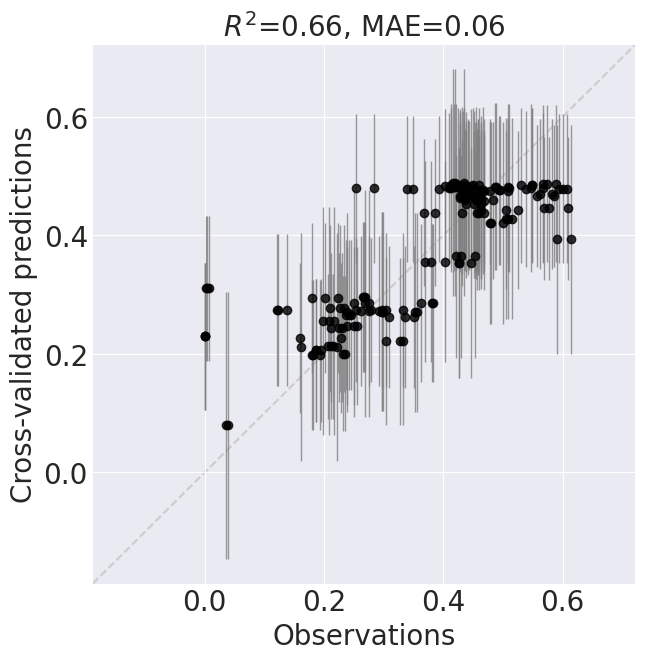

Building models…
Fitting L0 models…
Building TPOT models…


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(LinearSVR(VarianceThreshold(input_matrix, threshold=0.0005), C=0.001, dual=False, epsilon=0.0001, loss=squared_epsilon_insensitive, tol=0.01), learning_rate=0.001, loss=square, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(FastICA(FeatureAgglomeration(input_matrix, affinity=cosine, linkage=complete), tol=0.1), learning_rate=0.1, loss=exponential, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=0.01, loss=exponential, n_estimators=100)


Version 0.12.0 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: DecisionTreeRegressor(input_matrix, max_depth=3, min_samples_leaf=3, min_samples_split=5)
Done fitting L0 models in 457.10 s
Building ensemble model (4 sampling jobs)…


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, omegas]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 32 seconds.
/usr/local/art/.venv/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.


Done building ensemble model in 44.05 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,0.084023,116.914953,0.071185,0.012127,0.417020
Random Forest Regressor,0.016198,20.475888,0.018100,0.000590,0.971637
Support Vector Regressor,0.063237,349.420869,0.027288,0.004744,0.771962
Kernel Ridge Regressor,0.033485,88.843117,0.024594,0.001726,0.917023
K-NN Regressor,0.035800,14.309597,0.032992,0.002370,0.886062
Gaussian Process Regressor,0.016702,17.750221,0.018038,0.000604,0.970948
Gradient Boosting Regressor,0.015557,12.070272,0.017863,0.000561,0.973025
TPOT Regressor 1,0.035653,12.608997,0.034733,0.002477,0.880901
TPOT Regressor 2,0.038891,17.769969,0.029400,0.002377,0.885739


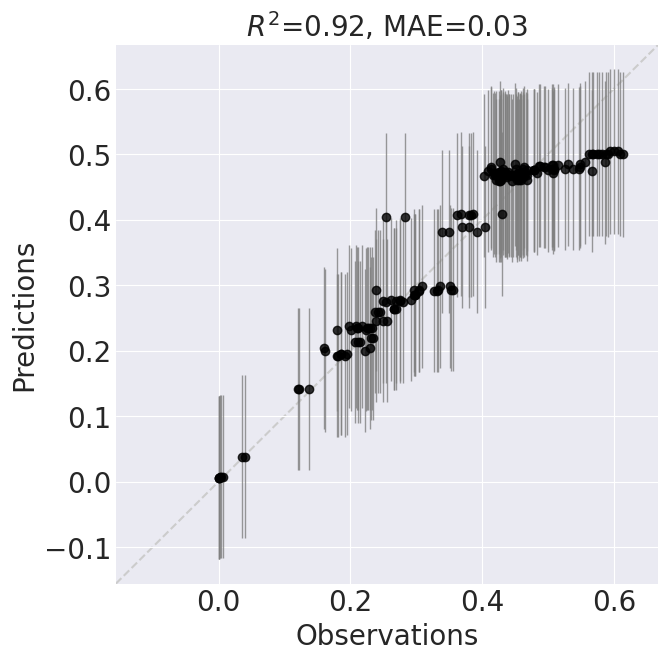

Done building models in 507.31 s


In [80]:
art = train_art(df_stacked, user_params, 'art_outliers_removed_2.cpkl')

In [81]:
# import cloudpickle as cpickle
# with open(user_params['output_dir'] + '/art_outliers_removed.cpkl', 'rb') as f:
#     art_old = cpickle.load(f)

In [49]:
def recommend_DE(art, user_params):
    def obj_func(x, art, draws):
        #print(x.shape)
        foo = art.post_pred_stats(x)
        #file1.write(str(x.flatten()[1:-1]))
        G = np.squeeze((1-art.alpha)*foo[0] +  art.alpha*foo[1])
        draws.append(np.append(x,G))

        return -G

    f = lambda x: obj_func(x,art, draws)
    draws = []
    result = differential_evolution(f, Bounds(art.bounds.values[:,0], art.bounds.values[:,1]), \
                                    maxiter = user_params['maxiter'], popsize= user_params['popsize'], vectorized = False)

    draws = np.array(draws) #make into a numpy array
    draws_padded = np.hstack((draws, np.reshape(draws[:,-1], [-1,1]))) # add an extra column in the end to achieve n_input_vars+2

    from art.core.recommender import Recommender

    recommender = Recommender(
                art.loader,
                art.create_bounds(),
                art._args,
                publish_recs=False,
                # ### Pass-through RE params  #######
                # self.input_vars,
                # self.num_recommendations,
                # self.output_dir,
                # self.rel_rec_distance,
                # self.response_vars,
                # self.testing,
                # self.verbose,
                # self.warning_callback,
            )
    recommendations = recommender.select(draws_padded)
    return recommendations

In [50]:
art.num_recommendations


16

In [51]:
from scipy.optimize import differential_evolution, Bounds
user_params['maxiter'] = 100
user_params['popsize'] = 500
art.alpha = user_params['alpha_explor']
art.num_recommendations = user_params['n_instances_explor']
art.rel_rec_distance = 2
recs_explore = recommend_DE(art, user_params)



Choosing recommendations (504,819 candidates)…


Done choosing recommendations in 1384.61 s


In [59]:
recs_explore

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM]
0,0.076872,0.673352,4.035057,0.044932,37.450241,1.085799,589.411309,0.000352,0.002470,0.005744,0.006587,0.000057
1,0.074569,0.710400,3.865275,0.043698,37.793069,1.002822,589.640781,0.000391,0.003163,0.005799,0.012223,0.000270
2,0.079391,0.805942,3.834796,0.047726,36.907150,1.195513,589.465451,0.000363,0.002957,0.005811,0.008507,0.000865
3,0.075384,0.509501,11.382077,0.045044,36.538656,1.226580,589.564078,0.000577,0.002424,0.005322,0.012354,0.000330
4,0.075269,0.865534,12.985539,0.035616,35.801194,1.375059,589.426056,0.000415,0.005296,0.005948,0.010879,0.001283


In [54]:
# user_params['maxiter'] = 1000
# user_params['popsize'] = 500
art.alpha = user_params['alpha_exploit']
art.num_recommendations = user_params['n_instances_exploit']
recs_exploit = recommend_DE(art, user_params)

Choosing recommendations (91,118 candidates)…


Done choosing recommendations in 35.75 s


In [57]:
recs_exploit.head(10)


,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM]
0,0.015919,0.229308,2.598355,0.060683,10.860956,0.374061,493.688987,0.000186,0.002130,0.001261,0.000849,0.000152
1,0.019222,0.307674,3.525611,0.058275,11.126672,0.964694,481.093379,0.000238,0.002163,0.001320,0.000315,0.000475
2,0.018093,0.806326,2.806326,0.058220,15.042509,0.636144,454.408830,0.000217,0.002151,0.001782,0.000297,0.000500
3,0.020716,0.854504,3.601388,0.063508,13.107555,0.614551,424.063716,0.000202,0.001614,0.001494,0.001120,0.000390
4,0.021665,0.716594,2.211578,0.058865,16.808802,0.379974,460.093519,0.000246,0.002152,0.001374,0.003696,0.000377
5,0.013484,0.476176,3.018758,0.058552,14.844126,1.035100,506.393128,0.000191,0.001317,0.001272,0.003978,0.000590
6,0.015771,0.596566,2.461602,0.057380,12.072126,0.556695,432.685654,0.000179,0.002404,0.003917,0.001158,0.000466
7,0.015798,0.801194,3.393851,0.066774,11.368197,0.590902,405.639898,0.000209,0.001154,0.003318,0.004075,0.000986
8,0.013997,0.864015,2.643108,0.057202,11.196264,0.248801,395.946558,0.000124,0.001649,0.002606,0.010950,0.000642
9,0.024340,0.817264,3.051005,0.064364,17.090542,1.095888,421.914934,0.000162,0.003515,0.001001,0.004470,0.000695


In [60]:
mean_exploit, std_exploit = art.post_pred_stats(recs_exploit.values)
mean_explore, std_explore = art.post_pred_stats(recs_explore.values)
recs_explore['OD340_pred'] = mean_explore 
recs_explore['OD340_std'] = std_explore 

recs_exploit['OD340_pred'] = mean_exploit 
recs_exploit['OD340_std'] = std_exploit 

In [61]:
recs_explore['Label'] = 'explore'
recs_exploit['Label'] = 'exploit'

In [62]:
recs_explore



,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
0,0.076872,0.673352,4.035057,0.044932,37.450241,1.085799,589.411309,0.000352,0.002470,0.005744,0.006587,0.000057,0.283741,0.085632,explore
1,0.074569,0.710400,3.865275,0.043698,37.793069,1.002822,589.640781,0.000391,0.003163,0.005799,0.012223,0.000270,0.283942,0.085551,explore
2,0.079391,0.805942,3.834796,0.047726,36.907150,1.195513,589.465451,0.000363,0.002957,0.005811,0.008507,0.000865,0.283642,0.085446,explore
3,0.075384,0.509501,11.382077,0.045044,36.538656,1.226580,589.564078,0.000577,0.002424,0.005322,0.012354,0.000330,0.284682,0.085168,explore
4,0.075269,0.865534,12.985539,0.035616,35.801194,1.375059,589.426056,0.000415,0.005296,0.005948,0.010879,0.001283,0.284426,0.084989,explore


In [63]:
recs_exploit.head(10)



,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
0,0.015919,0.229308,2.598355,0.060683,10.860956,0.374061,493.688987,0.000186,0.002130,0.001261,0.000849,0.000152,0.508962,0.064210,exploit
1,0.019222,0.307674,3.525611,0.058275,11.126672,0.964694,481.093379,0.000238,0.002163,0.001320,0.000315,0.000475,0.507346,0.064198,exploit
2,0.018093,0.806326,2.806326,0.058220,15.042509,0.636144,454.408830,0.000217,0.002151,0.001782,0.000297,0.000500,0.505593,0.064169,exploit
3,0.020716,0.854504,3.601388,0.063508,13.107555,0.614551,424.063716,0.000202,0.001614,0.001494,0.001120,0.000390,0.505020,0.064117,exploit
4,0.021665,0.716594,2.211578,0.058865,16.808802,0.379974,460.093519,0.000246,0.002152,0.001374,0.003696,0.000377,0.500023,0.063988,exploit
5,0.013484,0.476176,3.018758,0.058552,14.844126,1.035100,506.393128,0.000191,0.001317,0.001272,0.003978,0.000590,0.497605,0.063685,exploit
6,0.015771,0.596566,2.461602,0.057380,12.072126,0.556695,432.685654,0.000179,0.002404,0.003917,0.001158,0.000466,0.490655,0.063784,exploit
7,0.015798,0.801194,3.393851,0.066774,11.368197,0.590902,405.639898,0.000209,0.001154,0.003318,0.004075,0.000986,0.489814,0.063595,exploit
8,0.013997,0.864015,2.643108,0.057202,11.196264,0.248801,395.946558,0.000124,0.001649,0.002606,0.010950,0.000642,0.489417,0.063624,exploit
9,0.024340,0.817264,3.051005,0.064364,17.090542,1.095888,421.914934,0.000162,0.003515,0.001001,0.004470,0.000695,0.488578,0.063777,exploit


In [64]:
df_target = pd.concat([recs_explore, recs_exploit]).reset_index()
df_target.rename(columns={'OD340': 'OD340_pred'}, inplace=True)



In [65]:
df_target = df_target.drop(columns=['index'])
df_target.head()



,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
0,0.076872,0.673352,4.035057,0.044932,37.450241,1.085799,589.411309,0.000352,0.002470,0.005744,0.006587,0.000057,0.283741,0.085632,explore
1,0.074569,0.710400,3.865275,0.043698,37.793069,1.002822,589.640781,0.000391,0.003163,0.005799,0.012223,0.000270,0.283942,0.085551,explore
2,0.079391,0.805942,3.834796,0.047726,36.907150,1.195513,589.465451,0.000363,0.002957,0.005811,0.008507,0.000865,0.283642,0.085446,explore
3,0.075384,0.509501,11.382077,0.045044,36.538656,1.226580,589.564078,0.000577,0.002424,0.005322,0.012354,0.000330,0.284682,0.085168,explore
4,0.075269,0.865534,12.985539,0.035616,35.801194,1.375059,589.426056,0.000415,0.005296,0.005948,0.010879,0.001283,0.284426,0.084989,explore


In [66]:
user_params['standard_media_file']



'../flaviolin data/standard_recipe_concentrations.csv'

In [67]:
df_stand = pd.read_csv(user_params['standard_media_file']).set_index("Component")
df_stand = df_stand.rename(columns = {"Concentration":'Concentration[mM]'} )
df_stand



,Concentration[mM],Solubility
Component,,
MOPS[mM],40.00000,1700.00
Tricine[mM],4.00000,500.08
H3BO3[mM],0.00400,700.00
Glucose[mM],20.00000,5045.63
K2SO4[mM],0.29000,636.98
K2HPO4[mM],1.32000,8564.84
FeSO4[mM],0.01000,1645.73
NH4Cl[mM],9.52000,6543.28
MgCl2[mM],0.52000,569.27


In [68]:
ub = 1.1
lb = 0.9
df_control = pd.DataFrame(columns=user_params['components'])

for component in user_params['components']:
    stand_conc = df_stand.loc[component]['Concentration[mM]']
    df_control.at['Control', component] = stand_conc*np.random.uniform(lb, ub)

df_control

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM]
Control,0.004271,0.274219,1.31762,0.010676,8.594093,0.478488,45.121975,0.00003,0.000279,0.000095,0.000786,0.000091


In [69]:
for component in user_params['components'][:-1]:
     assert(all(df_control.at['Control', component] != control_lines[component]))

In [70]:
control_predicted_mean, control_predicted_std = art.post_pred_stats(
            df_control.values
        )
df_control['OD340_pred'] = control_predicted_mean
df_control['OD340_std'] = control_predicted_std
df_control['Label'] = 'standard'

In [71]:
df_control

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
Control,0.004271,0.274219,1.31762,0.010676,8.594093,0.478488,45.121975,0.00003,0.000279,0.000095,0.000786,0.000091,0.257194,0.063454,standard


In [111]:
df_train = df[user_params['components']]
df_train['OD340'] = df['OD340']
df_train

/tmp/ipykernel_83356/1512426963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['OD340'] = df['OD340']


Measurement Type,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340
0,0.019871,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.2076
1,0.019871,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.2149
2,0.019871,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.2124
3,0.003918,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,0.1955
4,0.003918,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,0.1859
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0.017924,0.690362,3.544519,0.057062,11.180931,0.886672,492.15367,0.000229,0.002112,0.000474,0.002997,0.000219,0.6004
175,0.017924,0.690362,3.544519,0.057062,11.180931,0.886672,492.15367,0.000229,0.002112,0.000474,0.002997,0.000219,0.6068
176,0.004165,0.287965,1.387221,0.0103,10.109658,0.517059,51.122061,0.000031,0.000287,0.000101,0.000851,0.000095,0.2427
177,0.004165,0.287965,1.387221,0.0103,10.109658,0.517059,51.122061,0.000031,0.000287,0.000101,0.000851,0.000095,0.2377


In [114]:
control_lines = df[df['Line Name'].str.find('_F8') > 0]


In [ ]:
train_predicted_mean, train_predicted_std = art.post_pred_stats(
            df_train.values[:, :-1]
        )
df_train['OD340_pred'] = train_predicted_mean
df_train['OD340_std'] = train_predicted_std
df_train['OD340_cv_pred'] = art.model_df_cv[0]["Predictions"]["Ensemble Model"]
df_train['OD340_cv_std'] = art.model_df_cv[0]["Predictions StDev"]["Ensemble Model"]


In [122]:
df_train['Label'] = 'train'
df_train.loc[control_lines.index, 'Label'] = 'standard'

In [123]:
df_train

Measurement Type,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340,OD340_pred,OD340_std,OD340_cv_pred,OD340_cv_std,Label
0,0.019871,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.2076,0.213173,0.063402,0.212983,0.062302,train
1,0.019871,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.2149,0.213173,0.063402,0.212983,0.062302,train
2,0.019871,0.205718,2.36508,0.021243,6.375749,4.320423,21.652901,0.000023,0.001306,0.0001,0.0008,0.0001,0.2124,0.213173,0.063402,0.212983,0.062302,train
3,0.003918,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,0.1955,0.195464,0.063414,0.205890,0.061215,train
4,0.003918,1.883663,0.799089,0.009532,8.860595,3.425574,15.010088,0.000102,0.000255,0.0001,0.0008,0.0001,0.1859,0.195464,0.063414,0.205890,0.061215,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0.017924,0.690362,3.544519,0.057062,11.180931,0.886672,492.15367,0.000229,0.002112,0.000474,0.002997,0.000219,0.6004,0.504505,0.064136,0.478739,0.064258,train
175,0.017924,0.690362,3.544519,0.057062,11.180931,0.886672,492.15367,0.000229,0.002112,0.000474,0.002997,0.000219,0.6068,0.504505,0.064136,0.478739,0.064258,train
176,0.004165,0.287965,1.387221,0.0103,10.109658,0.517059,51.122061,0.000031,0.000287,0.000101,0.000851,0.000095,0.2427,0.259687,0.063477,0.265148,0.064425,standard
177,0.004165,0.287965,1.387221,0.0103,10.109658,0.517059,51.122061,0.000031,0.000287,0.000101,0.000851,0.000095,0.2377,0.259687,0.063477,0.265148,0.064425,standard


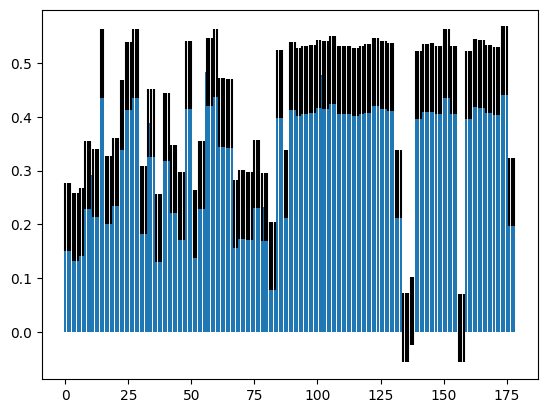

In [75]:
# df_train_no_duplicates = df_train.loc[list(range(2, 143, 3))]
#df_train_no_duplicates['OD340_pred'].plot.bar( yerr = df_train_no_duplicates['OD340_std'])
#plt.show()
fig, ax = plt.subplots()
ax.bar(df_train.index, df_train['OD340_pred'], yerr =df_train['OD340_std'] )
plt.show()

In [76]:

df_target_plot = pd.concat([recs_explore, recs_exploit]).reset_index()
df_target_plot.rename(columns={'OD340': 'OD340_pred'}, inplace=True)
df_target_plot = pd.concat([df_target_plot,df_control]).reset_index(drop=True)

df_target_plot.head()

,index,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
0,0.0,0.076872,0.673352,4.035057,0.044932,37.450241,1.085799,589.411309,0.000352,0.00247,0.005744,0.006587,0.000057,0.283741,0.085632,explore
1,1.0,0.074569,0.7104,3.865275,0.043698,37.793069,1.002822,589.640781,0.000391,0.003163,0.005799,0.012223,0.00027,0.283942,0.085551,explore
2,2.0,0.079391,0.805942,3.834796,0.047726,36.90715,1.195513,589.465451,0.000363,0.002957,0.005811,0.008507,0.000865,0.283642,0.085446,explore
3,3.0,0.075384,0.509501,11.382077,0.045044,36.538656,1.22658,589.564078,0.000577,0.002424,0.005322,0.012354,0.00033,0.284682,0.085168,explore
4,4.0,0.075269,0.865534,12.985539,0.035616,35.801194,1.375059,589.426056,0.000415,0.005296,0.005948,0.010879,0.001283,0.284426,0.084989,explore


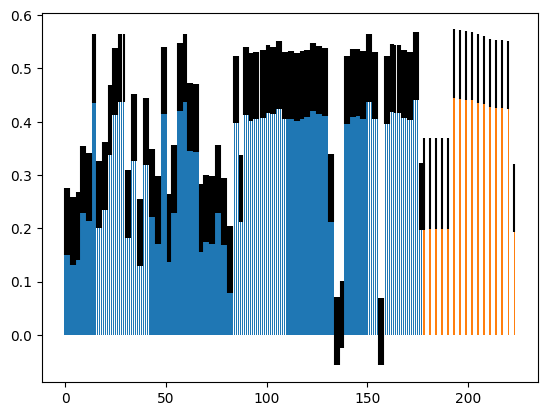

In [77]:
fig, ax = plt.subplots()
ax.bar(df_train.index, df_train['OD340_pred'], 
       yerr =df_train['OD340_std'] )
ax.bar(df_target_plot.index*3+max(df_train.index), df_target_plot['OD340_pred'], 
       yerr = df_target_plot['OD340_std'] )
plt.show()

In [124]:
file = f"{user_params['output_dir']}/train_pred.csv"
df_train.to_csv(file)
# df_target = pd.concat([df_target,df_control]).reset_index(drop=True)

In [79]:
df_target

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
0,0.076872,0.673352,4.035057,0.044932,37.450241,1.085799,589.411309,0.000352,0.00247,0.005744,0.006587,0.000057,0.283741,0.085632,explore
1,0.074569,0.7104,3.865275,0.043698,37.793069,1.002822,589.640781,0.000391,0.003163,0.005799,0.012223,0.00027,0.283942,0.085551,explore
2,0.079391,0.805942,3.834796,0.047726,36.90715,1.195513,589.465451,0.000363,0.002957,0.005811,0.008507,0.000865,0.283642,0.085446,explore
3,0.075384,0.509501,11.382077,0.045044,36.538656,1.22658,589.564078,0.000577,0.002424,0.005322,0.012354,0.00033,0.284682,0.085168,explore
4,0.075269,0.865534,12.985539,0.035616,35.801194,1.375059,589.426056,0.000415,0.005296,0.005948,0.010879,0.001283,0.284426,0.084989,explore
5,0.015919,0.229308,2.598355,0.060683,10.860956,0.374061,493.688987,0.000186,0.00213,0.001261,0.000849,0.000152,0.508962,0.064210,exploit
6,0.019222,0.307674,3.525611,0.058275,11.126672,0.964694,481.093379,0.000238,0.002163,0.00132,0.000315,0.000475,0.507346,0.064198,exploit
7,0.018093,0.806326,2.806326,0.05822,15.042509,0.636144,454.40883,0.000217,0.002151,0.001782,0.000297,0.0005,0.505593,0.064169,exploit
8,0.020716,0.854504,3.601388,0.063508,13.107555,0.614551,424.063716,0.000202,0.001614,0.001494,0.00112,0.00039,0.505020,0.064117,exploit
9,0.021665,0.716594,2.211578,0.058865,16.808802,0.379974,460.093519,0.000246,0.002152,0.001374,0.003696,0.000377,0.500023,0.063988,exploit


In [80]:
df_target = df_target.loc[df_target.index.repeat(user_params['n_replicates'])]
df_target

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
0,0.076872,0.673352,4.035057,0.044932,37.450241,1.085799,589.411309,0.000352,0.00247,0.005744,0.006587,0.000057,0.283741,0.085632,explore
0,0.076872,0.673352,4.035057,0.044932,37.450241,1.085799,589.411309,0.000352,0.00247,0.005744,0.006587,0.000057,0.283741,0.085632,explore
0,0.076872,0.673352,4.035057,0.044932,37.450241,1.085799,589.411309,0.000352,0.00247,0.005744,0.006587,0.000057,0.283741,0.085632,explore
1,0.074569,0.7104,3.865275,0.043698,37.793069,1.002822,589.640781,0.000391,0.003163,0.005799,0.012223,0.00027,0.283942,0.085551,explore
1,0.074569,0.7104,3.865275,0.043698,37.793069,1.002822,589.640781,0.000391,0.003163,0.005799,0.012223,0.00027,0.283942,0.085551,explore
1,0.074569,0.7104,3.865275,0.043698,37.793069,1.002822,589.640781,0.000391,0.003163,0.005799,0.012223,0.00027,0.283942,0.085551,explore
2,0.079391,0.805942,3.834796,0.047726,36.90715,1.195513,589.465451,0.000363,0.002957,0.005811,0.008507,0.000865,0.283642,0.085446,explore
2,0.079391,0.805942,3.834796,0.047726,36.90715,1.195513,589.465451,0.000363,0.002957,0.005811,0.008507,0.000865,0.283642,0.085446,explore
2,0.079391,0.805942,3.834796,0.047726,36.90715,1.195513,589.465451,0.000363,0.002957,0.005811,0.008507,0.000865,0.283642,0.085446,explore
3,0.075384,0.509501,11.382077,0.045044,36.538656,1.22658,589.564078,0.000577,0.002424,0.005322,0.012354,0.00033,0.284682,0.085168,explore


In [81]:
well_rows = 'ABCDEF'
well_columns = '12345678'
well_names = [f'{row}{column}'  for column in well_columns for row in well_rows]

df_target['Well'] = well_names
df_target = df_target.set_index(['Well'])
df_target.head()

,H3BO3[mM],K2SO4[mM],K2HPO4[mM],FeSO4[mM],NH4Cl[mM],MgCl2[mM],NaCl[mM],(NH4)6Mo7O24[mM],CoCl2[mM],CuSO4[mM],MnSO4[mM],ZnSO4[mM],OD340_pred,OD340_std,Label
Well,,,,,,,,,,,,,,,
A1,0.076872,0.673352,4.035057,0.044932,37.450241,1.085799,589.411309,0.000352,0.00247,0.005744,0.006587,0.000057,0.283741,0.085632,explore
B1,0.076872,0.673352,4.035057,0.044932,37.450241,1.085799,589.411309,0.000352,0.00247,0.005744,0.006587,0.000057,0.283741,0.085632,explore
C1,0.076872,0.673352,4.035057,0.044932,37.450241,1.085799,589.411309,0.000352,0.00247,0.005744,0.006587,0.000057,0.283741,0.085632,explore
D1,0.074569,0.7104,3.865275,0.043698,37.793069,1.002822,589.640781,0.000391,0.003163,0.005799,0.012223,0.00027,0.283942,0.085551,explore
E1,0.074569,0.7104,3.865275,0.043698,37.793069,1.002822,589.640781,0.000391,0.003163,0.005799,0.012223,0.00027,0.283942,0.085551,explore


In [82]:
f"{user_params['output_dir']}/target_concentrations.csv"


'../flaviolin data/DBTL5.1/target_concentrations.csv'

In [83]:
file = f"{user_params['output_dir']}/target_concentrations.csv"
df_target.to_csv(file) 